* Необходимо предсказать клас y на фичах a, b, c.

* Задание 1. Построить модель Pymc с множественной логистической регрессией для решения задачи. Предсказать класс на test_clf.

* Задание 2. Построить модель Pymc с порождающим множественным логистическим классификатором для решения задачи. Предсказать класс на test_clf.

* Каждое задание оценивается в 10 баллов

In [1]:
#!pip install pymc3

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

sns.set_style("whitegrid")

In [4]:
df = pd.read_csv("train_clf.csv")

In [5]:
df.head(3)

,a,b,c,y
0,6.061051,8.08512,-0.901515,0.0
1,8.625052,9.71248,0.410613,0.0
2,1.705775,0.67636,1.823731,1.0


In [6]:
X_train, X_test, y_train, y_test = train_test_split( df[['a', 'b', 'c']], df['y'], 
                                                    test_size=0.3, 
                                                    random_state=42)

In [7]:
print(f"X_train is {X_train.shape}")
print(f"X_test is {X_test.shape}")
print(f"y_train is {y_train.shape}")
print(f"y_test is {y_test.shape}")

X_train is (70, 3)
X_test is (30, 3)
y_train is (70,)
y_test is (30,)


In [8]:
y_train

11    0.0
47    1.0
85    1.0
28    0.0
93    1.0
     ... 
60    1.0
71    0.0
14    0.0
92    0.0
51    1.0
Name: y, Length: 70, dtype: float64

In [9]:
y = pd.Categorical(y_train).codes
scaler = StandardScaler()
X_train_tr = scaler.fit_transform(X_train)
X_test_tr = scaler.transform(X_test)

### Задание 1. Построить модель Pymc с множественной логистической регрессией для решения задачи. Предсказать класс на test_clf.

In [10]:
with pm.Model() as model_3: 
    α = pm.Normal('α', mu=0, sigma=10) 
    β = pm.StudentT('β', mu=0, sigma=2, nu=70, shape=len(['a', 'b', 'c'])) 
    μ = α + pm.math.dot(X_train_tr,β) 
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) 
    
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * X_train_tr[:,0])
    
    yl = pm.Bernoulli('yl', p=θ, observed=y) 
 
    trace = pm.sample(3000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 17 seconds.
/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [11]:
idx = np.argsort(X_train_tr[:,0]) 
bd = trace.posterior['bd'].mean(("chain", "draw"))[idx]

plt.scatter(X_train_transform[:,0], X_train_tr[:,1], c=[f'C{i}' for i in y]) 

plt.plot(X_train_tr[:,0][idx], bd, color='r'); 
az.plot_hdi(X_train_tr[:,0], trace.posterior['bd'], color='r')
 
plt.xlabel('a')
plt.ylabel('b')

NameError: name 'X_train_transform' is not defined

In [ ]:
α = trace.posterior['α'].mean(("chain", "draw")).values
β = trace.posterior["β"].mean(("chain", "draw")).values

μ = α + np.dot(X_test_tr, β)

predict = 1 / (1 + np.exp(-μ))

threshold = 0.5
y_pred = (predict > threshold).astype(int)
y_pred

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print(accuracy)
print(f1)

In [ ]:
az.summary(trace)

In [ ]:
az.plot_autocorr(trace, ['α', 'β']);

# Предсказание

In [ ]:
test = pd.read_csv('test_clf.csv')
test.head(3)

In [ ]:
X_test_tr = scaler.transform(test)

predict = 1 / (1 + np.exp(-α - np.dot(X_test_tr, β)))

y_predict = predict > 0.5
list(map(lambda x: int(x), y_predict))

### Задание 2. Построить модель Pymc с порождающим множественным логистическим классификатором для решения задачи. Предсказать класс на test_clf.

In [12]:
with pm.Model() as lda:
    μ = pm.Normal('μ', mu=0, sigma=20, shape=2)
    σ = pm.HalfNormal('σ', 10, shape=2)
    setosa = pm.Normal('a', mu=μ[0], sigma=σ[0], observed=X_train_tr) 
    versicolor = pm.Normal('b', mu=μ[1], sigma=σ[1], observed=X_train_tr) 
    
    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    trace_lda = pm.sample(2000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.


Text(0.5, 0, 'sepal_length')

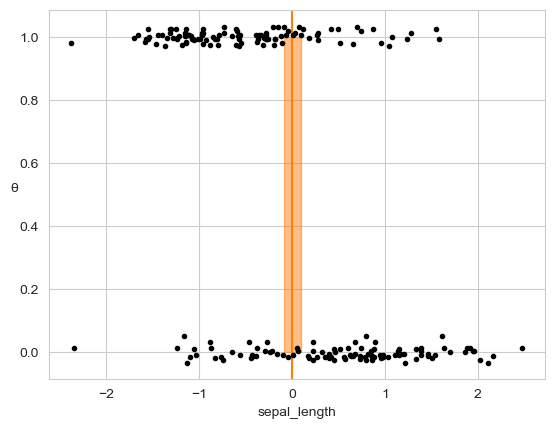

In [13]:
posterior_lda = trace_lda.posterior.stack(samples=("chain", "draw"))

plt.axvline(posterior_lda['bd'].mean(), ymax=1, color='C1')
bd_hpd = az.hdi(posterior_lda['bd'].values)

plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)

plt.plot(X_train_tr, np.random.normal(y, 0.02), '.', color='k')
plt.ylabel('θ', rotation=0)
plt.xlabel('sepal_length')

In [14]:
az.summary(trace_lda)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],-0.001,0.070,-0.136,0.127,0.001,0.001,12228.0,6409.0,1.0
μ[1],0.002,0.069,-0.126,0.131,0.001,0.001,12735.0,6836.0,1.0
σ[0],1.008,0.049,0.920,1.107,0.000,0.000,11907.0,6886.0,1.0
σ[1],1.009,0.049,0.920,1.104,0.000,0.000,14020.0,6363.0,1.0
bd,0.000,0.050,-0.091,0.094,0.000,0.001,11820.0,6751.0,1.0


In [15]:
with lda:
    posterior_samples = pm.sample_posterior_predictive(trace_lda)

Sampling: [a, b]


In [16]:
ppc_test = pm.sample_posterior_predictive(trace_lda, model=lda)

Sampling: [a, b]


In [17]:
y_pred = []
for i in X_test_tr.sum(axis=1):
    if i < posterior_lda['bd'].mean():
        y_pred.append(1)
    else:
        y_pred.append(0)

In [18]:
y_pred

[1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0]

In [19]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [100, 30]